In [1]:
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pingouin as pg
import pandas as pd

In [2]:
with open("data/prcc/master_df_parsed_150.pickle", "rb") as f:
    df = pickle.load(f)

In [3]:
df['speciation_bool'] = df['speciation_ybp'].notna()
df['speciation_ybp'] = 30000 - df['speciation_ybp']

In [4]:
# Speciation rate
n = 500
data = np.zeros((n, 14))
data[:,:12] = df.iloc[:, :12].drop_duplicates().values
data[:, 12] = df[df['food_scheme'] == 'constant'].groupby('param_set')['speciation_ybp'].mean().values
data[:, 13] = df[df['food_scheme'] == 'increasing'].groupby('param_set')['speciation_ybp'].mean().values

# Create a pandas df.
col_names = ['x' + str(n) for n in range(12)] + ['y1', 'y2']
data_composite_df = pd.DataFrame(data, columns=col_names)

In [5]:
# For each measurement, calculate the prcc value, a 95% CI, and p-value for each parameter.
prcc_point = [[],[]]; prcc_conf_intv =  [[],[]]; prcc_pval = [[],[]]
for n, measure in enumerate([-2, -1]):
    for p in range(12):

        # Drop rows where this measurement is nan.
        data_df = data_composite_df[data_composite_df[col_names[measure]].notna()]

        # Define the covariates as all other parameters that are varied in the LHS. 
        covars = col_names[:p] + col_names[p+1:-2]

        # Do the calculation and store the results! 
        z = pg.partial_corr(data_df, x=col_names[p], y=col_names[measure], covar=covars, method='spearman')
        prcc_point[n].append(z['r'][0]); prcc_conf_intv[n].append(z['CI95%'].values[0][1] - z['r'][0]); prcc_pval[n].append(z['p-val'][0])

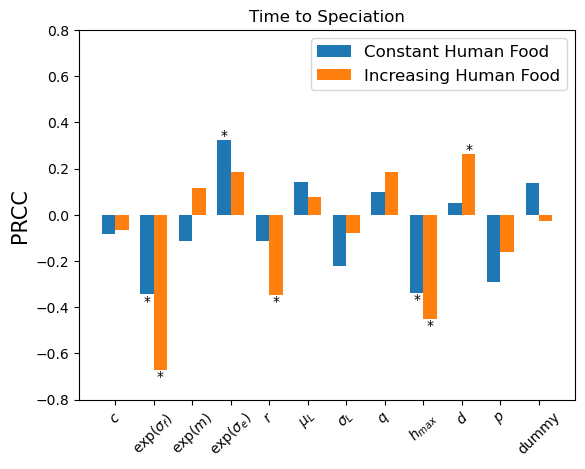

In [6]:
# Make the plot! 
ind = np.arange(len(prcc_point[0]))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, prcc_point[0], width,
                label='Constant Human Food')

for i, bar in enumerate(ax.containers[0]):
    if prcc_pval[0][i]< 0.05:
        if prcc_point[0][i] > 0:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02), va = 'center', ha = 'center')
        else:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03), va = 'center', ha = 'center')
            
rects2 = ax.bar(ind + width/2, prcc_point[1], width, label='Increasing Human Food')

for i, bar in enumerate(ax.containers[1]):
    if prcc_pval[1][i]< 0.05:
        if prcc_point[1][i] > 0:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02), va = 'center', ha = 'center')
        else:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03), va = 'center', ha = 'center')
          
ax.set_ylabel('PRCC', fontsize=15)
ax.set_xticks(ind)
ax.set_xticklabels([r'$c$',
 r'$\exp(\sigma_f)$',
 r'$\exp(m)$',
 r'$\exp(\sigma_e)$',
 r'$r$',
 r'$\mu_L$',
 r'$\sigma_L$',
 r'$q$',
 r'$h_{max}$',
 r'$d$',
 r'$p$',
 'dummy'], rotation = 45)
ax.legend(fontsize=12)
ax.set_ylim(-0.8, 0.8)
ax.set_title('Time to Speciation')
plt.savefig('figures/prcc/prcc_time_to_speciation_150.pdf', bbox_inches='tight')

In [7]:
# Streak
n = 500
data = np.zeros((n, 14))
data[:,:12] = df.iloc[:, :12].drop_duplicates().values
data[:, 12] = df[df['food_scheme'] == 'constant'].groupby('param_set')['max_streak'].mean().values
data[:, 13] = df[df['food_scheme'] == 'increasing'].groupby('param_set')['max_streak'].mean().values

# Create a pandas df.
col_names = ['x' + str(n) for n in range(12)] + ['y1', 'y2']
data_composite_df = pd.DataFrame(data, columns=col_names)

In [8]:
# For each measurement, calculate the prcc value, a 95% CI, and p-value for each parameter.
prcc_point = [[],[]]; prcc_conf_intv =  [[],[]]; prcc_pval = [[],[]]
for n, measure in enumerate([-2, -1]):
    for p in range(12):

        # Drop rows where this measurement is nan.
        data_df = data_composite_df[data_composite_df[col_names[measure]].notna()]

        # Define the covariates as all other parameters that are varied in the LHS. 
        covars = col_names[:p] + col_names[p+1:-2]

        # Do the calculation and store the results! 
        z = pg.partial_corr(data_df, x=col_names[p], y=col_names[measure], covar=covars, method='spearman')
        prcc_point[n].append(z['r'][0]); prcc_conf_intv[n].append(z['CI95%'].values[0][1] - z['r'][0]); prcc_pval[n].append(z['p-val'][0])

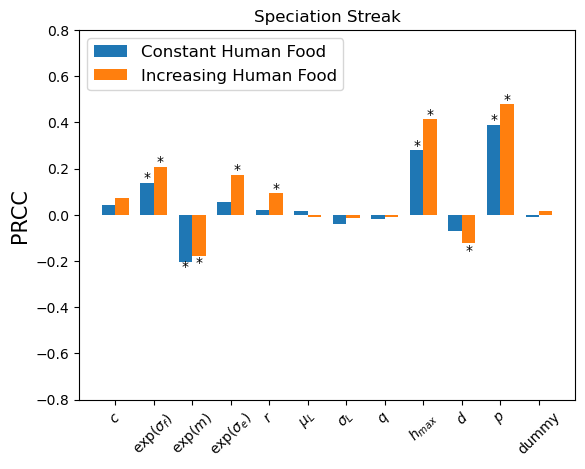

In [9]:
# Make the plot! 
ind = np.arange(len(prcc_point[0]))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, prcc_point[0], width,
                label='Constant Human Food')

for i, bar in enumerate(ax.containers[0]):
    if prcc_pval[0][i]< 0.05:
        if prcc_point[0][i] > 0:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02), va = 'center', ha = 'center')
        else:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02), va = 'center', ha = 'center')
  
rects2 = ax.bar(ind + width/2, prcc_point[1], width,
                label='Increasing Human Food')

for i, bar in enumerate(ax.containers[1]):
    if prcc_pval[1][i]< 0.05:
        if prcc_point[1][i] > 0:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02), va = 'center', ha = 'center')
        else:
            ax.annotate('*', xy = (bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03), va = 'center', ha = 'center')
          
ax.set_ylabel('PRCC', fontsize=15)
ax.set_xticks(ind)
ax.set_xticklabels([r'$c$',
 r'$\exp(\sigma_f)$',
 r'$\exp(m)$',
 r'$\exp(\sigma_e)$',
 r'$r$',
 r'$\mu_L$',
 r'$\sigma_L$',
 r'$q$',
 r'$h_{max}$',
 r'$d$',
 r'$p$',
 'dummy'], rotation = 45)
ax.legend(fontsize=12, loc = 'upper left')
ax.set_ylim(-0.8, 0.8)
ax.set_title('Speciation Streak')
plt.savefig('figures/prcc/prcc_speciation_streak_150.pdf', bbox_inches='tight')

In [23]:
df[df['speciation_bool']]['speciation_ybp'].median()

10825.0

In [24]:
df[df['speciation_bool']].groupby(['food_scheme'])['speciation_ybp'].median()

food_scheme
constant       7460.0
increasing    11315.0
Name: speciation_ybp, dtype: float64

In [20]:
df[df['speciation_bool']]['max_streak'].median()

318.5

In [21]:
df[df['speciation_bool']].groupby(['food_scheme'])['max_streak'].median()

food_scheme
constant      338.5
increasing    317.0
Name: max_streak, dtype: float64